<a href="https://colab.research.google.com/github/AndreRab/Ensamble-generation/blob/main/Experiment0_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependecies

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [51]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn

import matplotlib.pyplot as plt

import random

from tqdm import tqdm

from sklearn.metrics import accuracy_score
from torchmetrics.classification import MulticlassCalibrationError
import torch.nn.functional as F

import warnings
from typing import Iterable, Union, Tuple, Callable, Dict
import logging

from torch.nn.utils import parameters_to_vector, vector_to_parameters


## Hyper-parameters

In [52]:
batch_szie = 16
MNIST_size = 28

lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Dataset preporation

In [53]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_szie, shuffle=False)

In [55]:
def show_sample(dataset):
  index = random.randint(0, len(dataset) - 1)
  plt.imshow(dataset.data[index], cmap='gray')

def get_sample(dataset):
  index = random.randint(0, len(dataset) - 1)
  return dataset.data[index].view(1, -1).float()

get_sample(train_dataset).size()

torch.Size([1, 784])

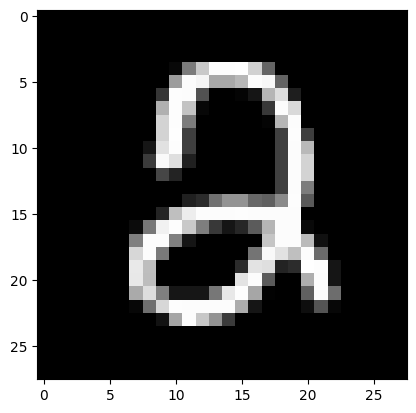

In [56]:
show_sample(train_dataset)

## Models

### Model's weights update functions

In [57]:
import torch
import logging
from typing import Dict

StateDict = Dict[str, torch.Tensor]

def _are_shapes_compatible(shape1, shape2):
    reversed_shape1 = reversed(shape1)
    reversed_shape2 = reversed(shape2)
    for dim1, dim2 in zip(reversed_shape1, reversed_shape2):
        if dim1 != dim2:
            return False
    return True

def _smart_reshape(tensor, desired_shape):
    tensor_num_elements = tensor.numel()
    desired_num_elements = torch.prod(torch.tensor(desired_shape)).item()
    if _are_shapes_compatible(tensor.shape, desired_shape):
        return tensor
    elif tensor_num_elements == desired_num_elements:
        return tensor.reshape(desired_shape)
    elif tensor_num_elements > desired_num_elements:
        extra_dim = tensor_num_elements // desired_num_elements
        new_shape = (extra_dim,) + desired_shape
        return tensor.reshape(new_shape)
    else:
        raise ValueError("The tensor has fewer elements than the desired shape.")

def load_partial_state_dict(
    module,
    state_dict: StateDict,
    prev_state_dict: StateDict = {},
    strict_shapes: bool = True,
):
    params_dict = dict(module.named_parameters())

    for param_path, new_value in state_dict.items():
        if param_path not in params_dict:
            logging.warning(f"[load_partial_state_dict] Parameter {param_path} not found in module.")
            continue

        current_param = params_dict[param_path]
        shape, new_shape = current_param.shape, new_value.shape

        assert (strict_shapes and new_shape == shape) or (
            not strict_shapes and (
                new_shape.numel() == shape.numel()
                or _are_shapes_compatible(new_shape, shape)
            )
        ), f"param_path={param_path} shape={new_shape} current shape={shape}"

        prev_state_dict[param_path] = current_param

        module_path, param_name = param_path.rsplit(".", 1) if "." in param_path else ("", param_path)
        parent_module = module
        if module_path:
            for name in module_path.split("."):
                parent_module = parent_module._modules[name]

        parent_module._parameters[param_name] = (
            new_value if new_shape == shape else _smart_reshape(new_value, shape)
        )

    return module

def load_state_dict(
    module,
    state_dict: StateDict,
    path="",
    prev_state_dict: StateDict = {},
    strict_shapes: bool = True,
):
    if len(state_dict) < 0.25 * len(list(module.parameters())):
        return load_partial_state_dict(
            module,
            state_dict,
            prev_state_dict=prev_state_dict,
            strict_shapes=strict_shapes,
        )

    for name, m in module._modules.items():
        load_state_dict(
            m,
            state_dict,
            path=f"{path}.{name}",
            prev_state_dict=prev_state_dict,
            strict_shapes=strict_shapes,
        )

    for name in module._parameters.keys():
        sample_path = f"{path}.{name}"[1:]  # remove leading dot

        if sample_path not in state_dict:
            continue
        new_value = state_dict[sample_path]
        shape, new_shape = module._parameters[name].shape, new_value.shape

        assert (strict_shapes and new_shape == shape) or (
            not strict_shapes and (
                new_shape.numel() == shape.numel()
                or _are_shapes_compatible(new_shape, shape)
            )
        ), f"sample_path={sample_path} shape={new_shape} current shape={shape}"

        prev_state_dict[sample_path] = module._parameters[name]
        module._parameters[name] = (
            new_value if new_shape == shape else _smart_reshape(new_value, shape)
        )

    return module

def vector_to_named_state_dict(model, vector):
    state_dict = {}
    offset = 0
    for name, param in model.named_parameters():
        numel = param.numel()
        shape = param.shape
        chunk = vector[0, offset:offset + numel].view(shape)
        state_dict[name] = chunk
        offset += numel
    return state_dict

### Base model

In [58]:
class OneLayerModel(nn.Module):
    def __init__(self, input_dim, classes_num, dropout_rate=0.5) -> None:
        self.input_dim = input_dim
        self.classes_num = classes_num
        super(OneLayerModel, self).__init__()
        self.linear = nn.Linear(input_dim, classes_num, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.linear(x)


In [59]:
base_model = OneLayerModel(MNIST_size * MNIST_size, 10)

In [60]:
def train_classic(model, train_loader, test_loader, num_epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    eval_losses = []
    ece_scores = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        eval_loss_total = 0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                probs = F.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)

                eval_loss_total += loss.item()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu())
                all_labels.extend(labels.cpu())
                all_probs.append(probs.cpu())

        eval_loss = eval_loss_total / len(test_loader)
        test_acc = correct / total
        all_probs_tensor = torch.cat(all_probs)
        all_labels_tensor = torch.tensor(all_labels)

        ece = MulticlassCalibrationError(num_classes=all_probs_tensor.shape[1], n_bins=15)
        ece_score = ece(all_probs_tensor, all_labels_tensor).item()

        eval_losses.append(eval_loss)
        test_accuracies.append(test_acc)
        ece_scores.append(ece_score)

        print(f"Epoch {epoch}: "
              f"Train Loss={avg_loss:.4f}, Train Acc={train_acc:.4f} | "
              f"Eval Loss={eval_loss:.4f}, Eval Acc={test_acc:.4f}, ECE={ece_score:.4f}")

    result = {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'train_accuracies': train_accuracies,
        'eval_accuracies': test_accuracies,
        'ece': ece_scores
    }

    return result

In [61]:
base_model_train_history = train_classic(base_model, train_loader, test_loader, device=device, num_epochs=20)

Epoch 1: 100%|██████████| 3750/3750 [00:14<00:00, 265.79it/s]


Epoch 1: Train Loss=0.5448, Train Acc=0.8478 | Eval Loss=0.3236, Eval Acc=0.9115, ECE=0.0495


Epoch 2: 100%|██████████| 3750/3750 [00:11<00:00, 340.36it/s]


Epoch 2: Train Loss=0.4413, Train Acc=0.8700 | Eval Loss=0.3057, Eval Acc=0.9156, ECE=0.0355


Epoch 3: 100%|██████████| 3750/3750 [00:10<00:00, 347.78it/s]


Epoch 3: Train Loss=0.4301, Train Acc=0.8728 | Eval Loss=0.3067, Eval Acc=0.9154, ECE=0.0300


Epoch 4: 100%|██████████| 3750/3750 [00:10<00:00, 347.05it/s]


Epoch 4: Train Loss=0.4266, Train Acc=0.8749 | Eval Loss=0.2995, Eval Acc=0.9181, ECE=0.0295


Epoch 5: 100%|██████████| 3750/3750 [00:10<00:00, 347.33it/s]


Epoch 5: Train Loss=0.4215, Train Acc=0.8771 | Eval Loss=0.2989, Eval Acc=0.9158, ECE=0.0219


Epoch 6: 100%|██████████| 3750/3750 [00:11<00:00, 338.07it/s]


Epoch 6: Train Loss=0.4222, Train Acc=0.8764 | Eval Loss=0.3031, Eval Acc=0.9152, ECE=0.0244


Epoch 7: 100%|██████████| 3750/3750 [00:11<00:00, 333.24it/s]


Epoch 7: Train Loss=0.4178, Train Acc=0.8774 | Eval Loss=0.3032, Eval Acc=0.9163, ECE=0.0215


Epoch 8: 100%|██████████| 3750/3750 [00:11<00:00, 340.24it/s]


Epoch 8: Train Loss=0.4255, Train Acc=0.8772 | Eval Loss=0.2997, Eval Acc=0.9179, ECE=0.0244


Epoch 9: 100%|██████████| 3750/3750 [00:11<00:00, 339.64it/s]


Epoch 9: Train Loss=0.4230, Train Acc=0.8768 | Eval Loss=0.3016, Eval Acc=0.9160, ECE=0.0225


Epoch 10: 100%|██████████| 3750/3750 [00:11<00:00, 338.67it/s]


Epoch 10: Train Loss=0.4240, Train Acc=0.8770 | Eval Loss=0.2968, Eval Acc=0.9178, ECE=0.0262


Epoch 11: 100%|██████████| 3750/3750 [00:11<00:00, 338.89it/s]


Epoch 11: Train Loss=0.4174, Train Acc=0.8786 | Eval Loss=0.2981, Eval Acc=0.9195, ECE=0.0229


Epoch 12: 100%|██████████| 3750/3750 [00:11<00:00, 338.85it/s]


Epoch 12: Train Loss=0.4187, Train Acc=0.8776 | Eval Loss=0.3081, Eval Acc=0.9172, ECE=0.0220


Epoch 13: 100%|██████████| 3750/3750 [00:10<00:00, 341.47it/s]


Epoch 13: Train Loss=0.4230, Train Acc=0.8769 | Eval Loss=0.3018, Eval Acc=0.9179, ECE=0.0194


Epoch 14: 100%|██████████| 3750/3750 [00:11<00:00, 340.88it/s]


Epoch 14: Train Loss=0.4195, Train Acc=0.8791 | Eval Loss=0.3043, Eval Acc=0.9192, ECE=0.0236


Epoch 15: 100%|██████████| 3750/3750 [00:10<00:00, 344.24it/s]


Epoch 15: Train Loss=0.4195, Train Acc=0.8790 | Eval Loss=0.3031, Eval Acc=0.9186, ECE=0.0227


Epoch 16: 100%|██████████| 3750/3750 [00:10<00:00, 343.00it/s]


Epoch 16: Train Loss=0.4214, Train Acc=0.8775 | Eval Loss=0.3137, Eval Acc=0.9145, ECE=0.0186


Epoch 17: 100%|██████████| 3750/3750 [00:10<00:00, 344.97it/s]


Epoch 17: Train Loss=0.4211, Train Acc=0.8781 | Eval Loss=0.3065, Eval Acc=0.9183, ECE=0.0233


Epoch 18: 100%|██████████| 3750/3750 [00:10<00:00, 343.38it/s]


Epoch 18: Train Loss=0.4169, Train Acc=0.8778 | Eval Loss=0.3022, Eval Acc=0.9196, ECE=0.0233


Epoch 19: 100%|██████████| 3750/3750 [00:10<00:00, 341.82it/s]


Epoch 19: Train Loss=0.4268, Train Acc=0.8770 | Eval Loss=0.3050, Eval Acc=0.9188, ECE=0.0221


Epoch 20: 100%|██████████| 3750/3750 [00:10<00:00, 345.90it/s]


Epoch 20: Train Loss=0.4215, Train Acc=0.8770 | Eval Loss=0.3032, Eval Acc=0.9191, ECE=0.0234


### Meta model

In [62]:
class MetaModelWithTwoLayers(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim=None):
    if not output_dim:
      output_dim = input_dim
    super(MetaModelWithTwoLayers, self).__init__()
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
    self.activation_fn = nn.ReLU()

  def forward(self, x):
    output = self.activation_fn(self.linear1(x))
    output = self.activation_fn(self.linear2(output))
    output = (self.linear3(output))

    return output

In [63]:
base_model_blank = OneLayerModel(MNIST_size * MNIST_size, 10)

ONE_LAYER_MODEL_PARAMETERS_SIZE = sum(p.numel() for p in base_model_blank.parameters() if p.requires_grad)
print(ONE_LAYER_MODEL_PARAMETERS_SIZE)
HIDDEN_LAYER_SIZE = int(ONE_LAYER_MODEL_PARAMETERS_SIZE / 4 * 3)
print(HIDDEN_LAYER_SIZE)

7840
5880


In [64]:
meta_model = MetaModelWithTwoLayers(ONE_LAYER_MODEL_PARAMETERS_SIZE, HIDDEN_LAYER_SIZE)

### Train and evaluate loop

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = meta_model.parameters(), lr=lr)

In [66]:
def random_half_mask_generation(size):
    num_ones = size // 2
    num_zeros = size - num_ones
    mask = torch.cat([torch.ones(num_ones), torch.zeros(num_zeros)])
    return mask[torch.randperm(size)]


def generate_noise_vector(mask, size):
    return (mask * torch.randn(size)).view(1, -1)


def train_epoch(meta_model, base_model, criterion, optimizer, train_loader, device):
    loss_by_epoch = []
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        parameters = parameters_to_vector(base_model.parameters()).to(device)
        mask = random_half_mask_generation(parameters.numel())
        meta_model_input = generate_noise_vector(mask, parameters.numel()).to(device)
        new_weights = meta_model(meta_model_input) * mask.view(1, -1).to(device)

        new_weights_dict = vector_to_named_state_dict(base_model, new_weights)
        load_state_dict(base_model, new_weights_dict)

        outputs = base_model(inputs)
        loss = criterion(outputs, labels)
        loss_by_epoch.append(loss.item())

        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    res = {
        'loss': sum(loss_by_epoch) / len(loss_by_epoch),
        'acc': accuracy_score(all_labels, all_preds),
    }
    return res


def generate_new_model(new_weights, input_dim, classes_num):
    model = OneLayerModel(input_dim, classes_num)
    new_weights_dict = vector_to_named_state_dict(model, new_weights)
    load_state_dict(model, new_weights_dict)
    return model


def get_ensemble(meta_model, base_model, device, num_models):
    ensemble = []
    param_size = parameters_to_vector(base_model.parameters()).numel()
    for _ in range(num_models):
        mask = random_half_mask_generation(param_size)
        meta_input = generate_noise_vector(mask, param_size).to(device)
        new_weights = meta_model(meta_input) * mask.view(1, -1).to(device)
        model = generate_new_model(new_weights, base_model.input_dim, base_model.classes_num).to(device)
        model.eval()
        ensemble.append(model)
    return ensemble


def get_ensemble_results(ensemble, inputs):
    outputs = [torch.softmax(model(inputs), dim=1) for model in ensemble]
    stacked_outputs = torch.stack(outputs)

    mean_probs = torch.mean(stacked_outputs, dim=0)
    var_probs = torch.var(stacked_outputs, dim=0)
    median_probs = torch.median(stacked_outputs, dim=0).values

    return mean_probs, var_probs, median_probs


def eval_epoch(meta_model, base_model, criterion, eval_loader, device, number_of_models_in_ensemble=10):
    loss_by_epoch = []
    all_preds = []
    all_labels = []
    all_probs = []
    all_var_probs = []
    all_median_probs = []

    ensemble = get_ensemble(meta_model, base_model, device, number_of_models_in_ensemble)

    for batch in tqdm(eval_loader):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            mean_probs, var_probs, median_probs = get_ensemble_results(ensemble, inputs)
            loss = criterion(mean_probs, labels)

        loss_by_epoch.append(loss.item())
        preds = mean_probs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.append(mean_probs.cpu())
        all_var_probs.append(var_probs.cpu())
        all_median_probs.append(median_probs.cpu())

    all_probs_tensor = torch.cat(all_probs, dim=0)
    all_var_tensor = torch.cat(all_var_probs, dim=0)
    all_median_tensor = torch.cat(all_median_probs, dim=0)
    all_labels_tensor = torch.tensor(all_labels)

    ece = MulticlassCalibrationError(num_classes=all_probs_tensor.size(1), n_bins=15)
    ece_score = ece(all_probs_tensor, all_labels_tensor).item()

    res = {
        'loss': sum(loss_by_epoch) / len(loss_by_epoch),
        'acc': accuracy_score(all_labels, all_preds),
        'ece': ece_score,
        'mean_variance': all_var_tensor.mean().item(),
    }

    return res

In [67]:
def train_and_eval(num_epochs, meta_model, base_model, criterion, optimizer, train_loader, eval_loader, device='cpu'):
    meta_model.to(device)
    base_model.to(device)
    base_model.eval()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []
    eval_var = []
    ece = []

    for epoch in range(1, num_epochs + 1):
        meta_model.train()
        results = train_epoch(meta_model, base_model, criterion, optimizer, train_loader, device)
        train_loss, train_acc, = results['loss'], results['acc']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        meta_model.eval()
        results = eval_epoch(meta_model, base_model, criterion, eval_loader, device)
        eval_loss, eval_acc, eval_ece, eval_mean_var = results['loss'], results['acc'], results['ece'], results['mean_variance']
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_acc)
        eval_var.append(eval_mean_var)
        ece.append(eval_ece)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Eval Loss={eval_loss:.4f}, Acc={eval_acc:.4f}, Ece={eval_ece:.4f}")

    res = {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'train_accuracies': train_accuracies,
        'eval_accuracies' : eval_accuracies,
        'eval_var': eval_var,
        'ece': ece
    }

    return res

def compare_train_results(ensamble_res, base_res=None):
    ensamble_train_losses = ensamble_res['train_losses']
    ensamble_eval_losses = ensamble_res['eval_losses']
    ensamble_train_accuracies = ensamble_res['train_accuracies']
    ensamble_eval_accuracies = ensamble_res['eval_accuracies']
    ensamble_ece = ensamble_res['ece']

    base_train_losses = base_eval_losses = []
    base_train_accuracies = base_eval_accuracies = []
    base_ece = []

    if base_res:
        base_train_losses = base_res['train_losses']
        base_eval_losses = base_res['eval_losses']
        base_train_accuracies = base_res['train_accuracies']
        base_eval_accuracies = base_res['eval_accuracies']
        base_ece = base_res['ece']

    fig, axs = plt.subplots(2, 3, figsize=(18, 8))

    axs[0, 0].plot(ensamble_train_losses, c='r', label='Train Loss ensamble')
    axs[0, 0].plot(ensamble_eval_losses, c='b', label='Eval Loss ensamble')
    if base_res:
        axs[0, 0].plot(base_eval_losses, c='g', label='Eval Loss base')
    axs[0, 0].set_title("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(ensamble_train_accuracies, c='r', label='Train Acc ensamble')
    axs[0, 1].plot(ensamble_eval_accuracies, c='b', label='Eval Acc ensamble')
    if base_res:
        axs[0, 1].plot(base_eval_accuracies, c='g', label='Eval Acc base')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].legend()

    axs[0, 2].plot(ensamble_ece, c='b', label='Eval Ece ensamble')
    if base_res:
        axs[0, 2].plot(base_ece, c='g', label='Eval Ece base')
    axs[0, 2].set_title("ECE")
    axs[0, 2].legend()

    axs[1, 0].plot(ensamble_res['eval_var'], c='b', label='Variance ensamble')
    axs[1, 0].set_title("Variance")
    axs[1, 0].legend()


    fig.delaxes(axs[1, 1])
    fig.delaxes(axs[1, 2])
    plt.tight_layout()
    plt.show()

In [68]:
ensamble_train_history = train_and_eval(20, meta_model, base_model_blank, criterion, optimizer, train_loader, test_loader, device)


100%|██████████| 3750/3750 [00:50<00:00, 74.81it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 342.25it/s]


Epoch 1: Train Loss=0.6207, Acc=0.8120 | Eval Loss=1.6675, Acc=0.9041, Ece=0.0987


100%|██████████| 3750/3750 [00:50<00:00, 74.65it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 369.86it/s]


Epoch 2: Train Loss=0.4882, Acc=0.8522 | Eval Loss=1.6551, Acc=0.9034, Ece=0.0857


100%|██████████| 3750/3750 [00:50<00:00, 74.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 368.61it/s]


Epoch 3: Train Loss=0.4741, Acc=0.8582 | Eval Loss=1.6549, Acc=0.9101, Ece=0.0942


100%|██████████| 3750/3750 [00:50<00:00, 74.73it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 381.58it/s]


Epoch 4: Train Loss=0.4664, Acc=0.8618 | Eval Loss=1.6508, Acc=0.9043, Ece=0.0799


100%|██████████| 3750/3750 [00:50<00:00, 74.64it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 385.08it/s]


Epoch 5: Train Loss=0.4632, Acc=0.8608 | Eval Loss=1.6385, Acc=0.9090, Ece=0.0712


100%|██████████| 3750/3750 [00:50<00:00, 74.74it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 378.11it/s]


Epoch 6: Train Loss=0.4584, Acc=0.8623 | Eval Loss=1.6437, Acc=0.9137, Ece=0.0852


100%|██████████| 3750/3750 [00:50<00:00, 74.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 381.77it/s]


Epoch 7: Train Loss=0.4516, Acc=0.8677 | Eval Loss=1.6388, Acc=0.9137, Ece=0.0781


100%|██████████| 3750/3750 [00:50<00:00, 74.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 333.56it/s]


Epoch 8: Train Loss=0.4504, Acc=0.8653 | Eval Loss=1.6514, Acc=0.9097, Ece=0.0879


100%|██████████| 3750/3750 [00:50<00:00, 74.64it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 350.90it/s]


Epoch 9: Train Loss=0.4469, Acc=0.8667 | Eval Loss=1.6361, Acc=0.9142, Ece=0.0770


100%|██████████| 3750/3750 [00:50<00:00, 74.27it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 364.75it/s]


Epoch 10: Train Loss=0.4500, Acc=0.8657 | Eval Loss=1.6519, Acc=0.9045, Ece=0.0821


100%|██████████| 3750/3750 [00:50<00:00, 74.37it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 338.61it/s]


Epoch 11: Train Loss=0.4436, Acc=0.8685 | Eval Loss=1.6375, Acc=0.9085, Ece=0.0694


100%|██████████| 3750/3750 [00:50<00:00, 74.64it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 372.62it/s]


Epoch 12: Train Loss=0.4433, Acc=0.8673 | Eval Loss=1.6362, Acc=0.9107, Ece=0.0727


100%|██████████| 3750/3750 [00:50<00:00, 74.58it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 372.25it/s]


Epoch 13: Train Loss=0.4393, Acc=0.8698 | Eval Loss=1.6342, Acc=0.9109, Ece=0.0704


100%|██████████| 3750/3750 [00:50<00:00, 74.60it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 309.56it/s]


Epoch 14: Train Loss=0.4412, Acc=0.8703 | Eval Loss=1.6369, Acc=0.9126, Ece=0.0751


100%|██████████| 3750/3750 [00:50<00:00, 74.66it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 377.40it/s]


Epoch 15: Train Loss=0.4357, Acc=0.8710 | Eval Loss=1.6383, Acc=0.9115, Ece=0.0757


100%|██████████| 3750/3750 [00:50<00:00, 74.72it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 376.36it/s]


Epoch 16: Train Loss=0.4395, Acc=0.8704 | Eval Loss=1.6346, Acc=0.9137, Ece=0.0738


100%|██████████| 3750/3750 [00:50<00:00, 74.69it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 317.37it/s]


Epoch 17: Train Loss=0.4408, Acc=0.8707 | Eval Loss=1.6401, Acc=0.9099, Ece=0.0746


100%|██████████| 3750/3750 [00:50<00:00, 74.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 383.88it/s]


Epoch 18: Train Loss=0.4363, Acc=0.8709 | Eval Loss=1.6381, Acc=0.9116, Ece=0.0744


100%|██████████| 3750/3750 [00:50<00:00, 74.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 380.92it/s]


Epoch 19: Train Loss=0.4322, Acc=0.8715 | Eval Loss=1.6398, Acc=0.9115, Ece=0.0758


100%|██████████| 3750/3750 [00:50<00:00, 74.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 306.09it/s]

Epoch 20: Train Loss=0.4353, Acc=0.8715 | Eval Loss=1.6335, Acc=0.9143, Ece=0.0740


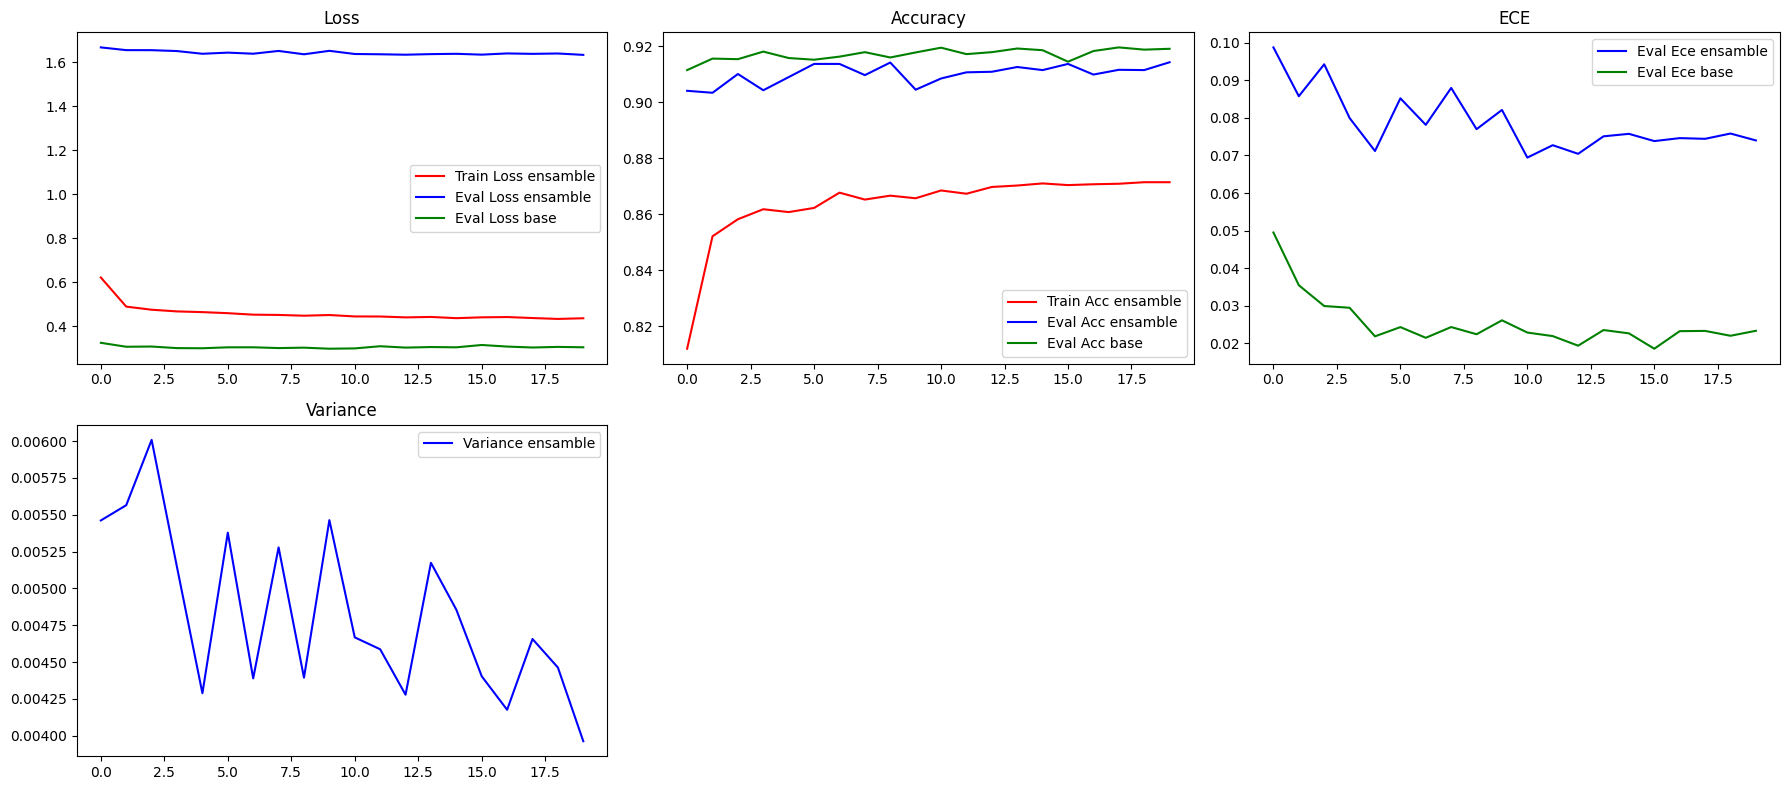

In [70]:
compare_train_results(ensamble_train_history, base_model_train_history)

Next 20 epochs extra

In [71]:
base_model_train_history_extra_20 = train_classic(base_model, train_loader, test_loader, device=device, num_epochs=20)

Epoch 1: 100%|██████████| 3750/3750 [00:14<00:00, 252.20it/s]


Epoch 1: Train Loss=0.4221, Train Acc=0.8785 | Eval Loss=0.3037, Eval Acc=0.9196, ECE=0.0218


Epoch 2: 100%|██████████| 3750/3750 [00:10<00:00, 342.67it/s]


Epoch 2: Train Loss=0.4233, Train Acc=0.8767 | Eval Loss=0.3070, Eval Acc=0.9185, ECE=0.0213


Epoch 3: 100%|██████████| 3750/3750 [00:15<00:00, 246.92it/s]


Epoch 3: Train Loss=0.4201, Train Acc=0.8786 | Eval Loss=0.3070, Eval Acc=0.9185, ECE=0.0187


Epoch 4: 100%|██████████| 3750/3750 [00:13<00:00, 276.64it/s]


Epoch 4: Train Loss=0.4206, Train Acc=0.8783 | Eval Loss=0.3085, Eval Acc=0.9181, ECE=0.0206


Epoch 5: 100%|██████████| 3750/3750 [00:11<00:00, 335.77it/s]


Epoch 5: Train Loss=0.4178, Train Acc=0.8771 | Eval Loss=0.3048, Eval Acc=0.9196, ECE=0.0220


Epoch 6: 100%|██████████| 3750/3750 [00:10<00:00, 343.45it/s]


Epoch 6: Train Loss=0.4206, Train Acc=0.8765 | Eval Loss=0.3079, Eval Acc=0.9195, ECE=0.0218


Epoch 7: 100%|██████████| 3750/3750 [00:10<00:00, 343.17it/s]


Epoch 7: Train Loss=0.4179, Train Acc=0.8784 | Eval Loss=0.3031, Eval Acc=0.9185, ECE=0.0224


Epoch 8: 100%|██████████| 3750/3750 [00:11<00:00, 340.10it/s]


Epoch 8: Train Loss=0.4178, Train Acc=0.8794 | Eval Loss=0.3052, Eval Acc=0.9193, ECE=0.0200


Epoch 9: 100%|██████████| 3750/3750 [00:10<00:00, 342.90it/s]


Epoch 9: Train Loss=0.4143, Train Acc=0.8784 | Eval Loss=0.3088, Eval Acc=0.9173, ECE=0.0216


Epoch 10: 100%|██████████| 3750/3750 [00:10<00:00, 341.35it/s]


Epoch 10: Train Loss=0.4190, Train Acc=0.8789 | Eval Loss=0.3049, Eval Acc=0.9178, ECE=0.0226


Epoch 11: 100%|██████████| 3750/3750 [00:10<00:00, 342.29it/s]


Epoch 11: Train Loss=0.4153, Train Acc=0.8788 | Eval Loss=0.3057, Eval Acc=0.9201, ECE=0.0232


Epoch 12: 100%|██████████| 3750/3750 [00:10<00:00, 343.08it/s]


Epoch 12: Train Loss=0.4199, Train Acc=0.8777 | Eval Loss=0.3101, Eval Acc=0.9169, ECE=0.0223


Epoch 13: 100%|██████████| 3750/3750 [00:10<00:00, 341.17it/s]


Epoch 13: Train Loss=0.4166, Train Acc=0.8808 | Eval Loss=0.3087, Eval Acc=0.9168, ECE=0.0181


Epoch 14: 100%|██████████| 3750/3750 [00:11<00:00, 334.03it/s]


Epoch 14: Train Loss=0.4203, Train Acc=0.8784 | Eval Loss=0.3109, Eval Acc=0.9179, ECE=0.0187


Epoch 15: 100%|██████████| 3750/3750 [00:10<00:00, 343.32it/s]


Epoch 15: Train Loss=0.4182, Train Acc=0.8786 | Eval Loss=0.3060, Eval Acc=0.9189, ECE=0.0241


Epoch 16: 100%|██████████| 3750/3750 [00:10<00:00, 343.10it/s]


Epoch 16: Train Loss=0.4205, Train Acc=0.8777 | Eval Loss=0.3053, Eval Acc=0.9202, ECE=0.0217


Epoch 17: 100%|██████████| 3750/3750 [00:11<00:00, 335.49it/s]


Epoch 17: Train Loss=0.4196, Train Acc=0.8777 | Eval Loss=0.3095, Eval Acc=0.9195, ECE=0.0191


Epoch 18: 100%|██████████| 3750/3750 [00:10<00:00, 340.97it/s]


Epoch 18: Train Loss=0.4225, Train Acc=0.8787 | Eval Loss=0.3084, Eval Acc=0.9190, ECE=0.0197


Epoch 19: 100%|██████████| 3750/3750 [00:10<00:00, 341.70it/s]


Epoch 19: Train Loss=0.4208, Train Acc=0.8797 | Eval Loss=0.3103, Eval Acc=0.9191, ECE=0.0204


Epoch 20: 100%|██████████| 3750/3750 [00:10<00:00, 342.46it/s]


Epoch 20: Train Loss=0.4207, Train Acc=0.8782 | Eval Loss=0.3097, Eval Acc=0.9185, ECE=0.0173


In [72]:
ensamble_train_history_extra_20 = train_and_eval(20, meta_model, base_model_blank, criterion, optimizer, train_loader, test_loader, device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 3750/3750 [00:50<00:00, 74.03it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Ten

Epoch 1: Train Loss=0.4344, Acc=0.8717 | Eval Loss=1.6391, Acc=0.9107, Ece=0.0761


100%|██████████| 3750/3750 [00:50<00:00, 74.68it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 371.79it/s]


Epoch 2: Train Loss=0.4342, Acc=0.8725 | Eval Loss=1.6372, Acc=0.9050, Ece=0.0639


100%|██████████| 3750/3750 [00:50<00:00, 74.73it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 364.91it/s]


Epoch 3: Train Loss=0.4319, Acc=0.8706 | Eval Loss=1.6347, Acc=0.9141, Ece=0.0750


100%|██████████| 3750/3750 [00:50<00:00, 74.66it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 374.66it/s]


Epoch 4: Train Loss=0.4268, Acc=0.8735 | Eval Loss=1.6345, Acc=0.9152, Ece=0.0755


100%|██████████| 3750/3750 [00:50<00:00, 74.74it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 376.49it/s]


Epoch 5: Train Loss=0.4326, Acc=0.8703 | Eval Loss=1.6399, Acc=0.9157, Ece=0.0832


100%|██████████| 3750/3750 [00:50<00:00, 74.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 379.41it/s]


Epoch 6: Train Loss=0.4317, Acc=0.8719 | Eval Loss=1.6322, Acc=0.9121, Ece=0.0693


100%|██████████| 3750/3750 [00:50<00:00, 74.67it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 324.72it/s]


Epoch 7: Train Loss=0.4295, Acc=0.8728 | Eval Loss=1.6360, Acc=0.9132, Ece=0.0746


100%|██████████| 3750/3750 [00:50<00:00, 74.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 384.39it/s]


Epoch 8: Train Loss=0.4293, Acc=0.8741 | Eval Loss=1.6407, Acc=0.9131, Ece=0.0803


100%|██████████| 3750/3750 [00:50<00:00, 74.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 381.87it/s]


Epoch 9: Train Loss=0.4253, Acc=0.8741 | Eval Loss=1.6421, Acc=0.9075, Ece=0.0725


100%|██████████| 3750/3750 [00:50<00:00, 74.71it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 306.99it/s]


Epoch 10: Train Loss=0.4311, Acc=0.8720 | Eval Loss=1.6332, Acc=0.9133, Ece=0.0717


100%|██████████| 3750/3750 [00:50<00:00, 74.76it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 375.90it/s]


Epoch 11: Train Loss=0.4280, Acc=0.8725 | Eval Loss=1.6333, Acc=0.9103, Ece=0.0679


100%|██████████| 3750/3750 [00:50<00:00, 74.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 386.08it/s]


Epoch 12: Train Loss=0.4299, Acc=0.8744 | Eval Loss=1.6351, Acc=0.9140, Ece=0.0743


100%|██████████| 3750/3750 [00:50<00:00, 74.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 263.90it/s]


Epoch 13: Train Loss=0.4290, Acc=0.8737 | Eval Loss=1.6424, Acc=0.9142, Ece=0.0848


100%|██████████| 3750/3750 [00:50<00:00, 74.75it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 378.63it/s]


Epoch 14: Train Loss=0.4279, Acc=0.8739 | Eval Loss=1.6346, Acc=0.9150, Ece=0.0768


100%|██████████| 3750/3750 [00:50<00:00, 74.81it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 384.88it/s]


Epoch 15: Train Loss=0.4266, Acc=0.8733 | Eval Loss=1.6444, Acc=0.9137, Ece=0.0856


100%|██████████| 3750/3750 [00:50<00:00, 74.80it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 287.47it/s]


Epoch 16: Train Loss=0.4280, Acc=0.8729 | Eval Loss=1.6437, Acc=0.9123, Ece=0.0833


100%|██████████| 3750/3750 [00:50<00:00, 74.79it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 377.83it/s]


Epoch 17: Train Loss=0.4259, Acc=0.8735 | Eval Loss=1.6418, Acc=0.9141, Ece=0.0828


100%|██████████| 3750/3750 [00:50<00:00, 74.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 381.91it/s]


Epoch 18: Train Loss=0.4228, Acc=0.8745 | Eval Loss=1.6335, Acc=0.9135, Ece=0.0724


100%|██████████| 3750/3750 [00:50<00:00, 74.87it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:02<00:00, 274.94it/s]


Epoch 19: Train Loss=0.4256, Acc=0.8748 | Eval Loss=1.6395, Acc=0.9147, Ece=0.0818


100%|██████████| 3750/3750 [00:50<00:00, 74.83it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:938: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad
100%|██████████| 625/625 [00:01<00:00, 386.89it/s]

Epoch 20: Train Loss=0.4304, Acc=0.8733 | Eval Loss=1.6318, Acc=0.9129, Ece=0.0695


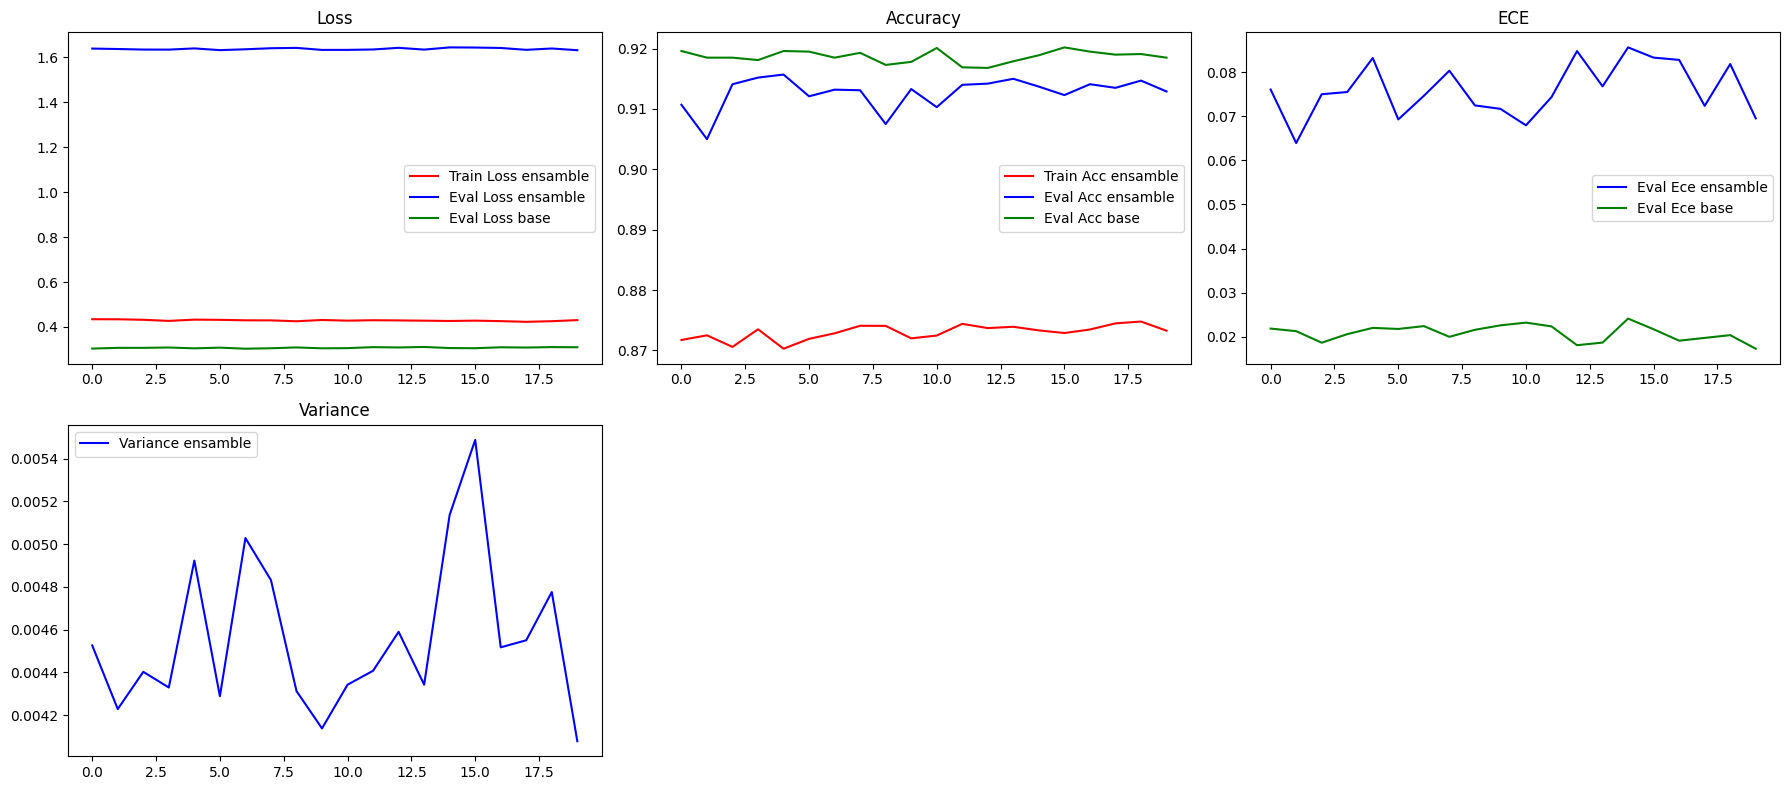

In [73]:
compare_train_results(ensamble_train_history_extra_20, base_model_train_history_extra_20)

Final plots

In [75]:
for key in ensamble_train_history:
  ensamble_train_history[key].extend(ensamble_train_history_extra_20[key])

for key in base_model_train_history:
  base_model_train_history[key].extend(base_model_train_history_extra_20[key])

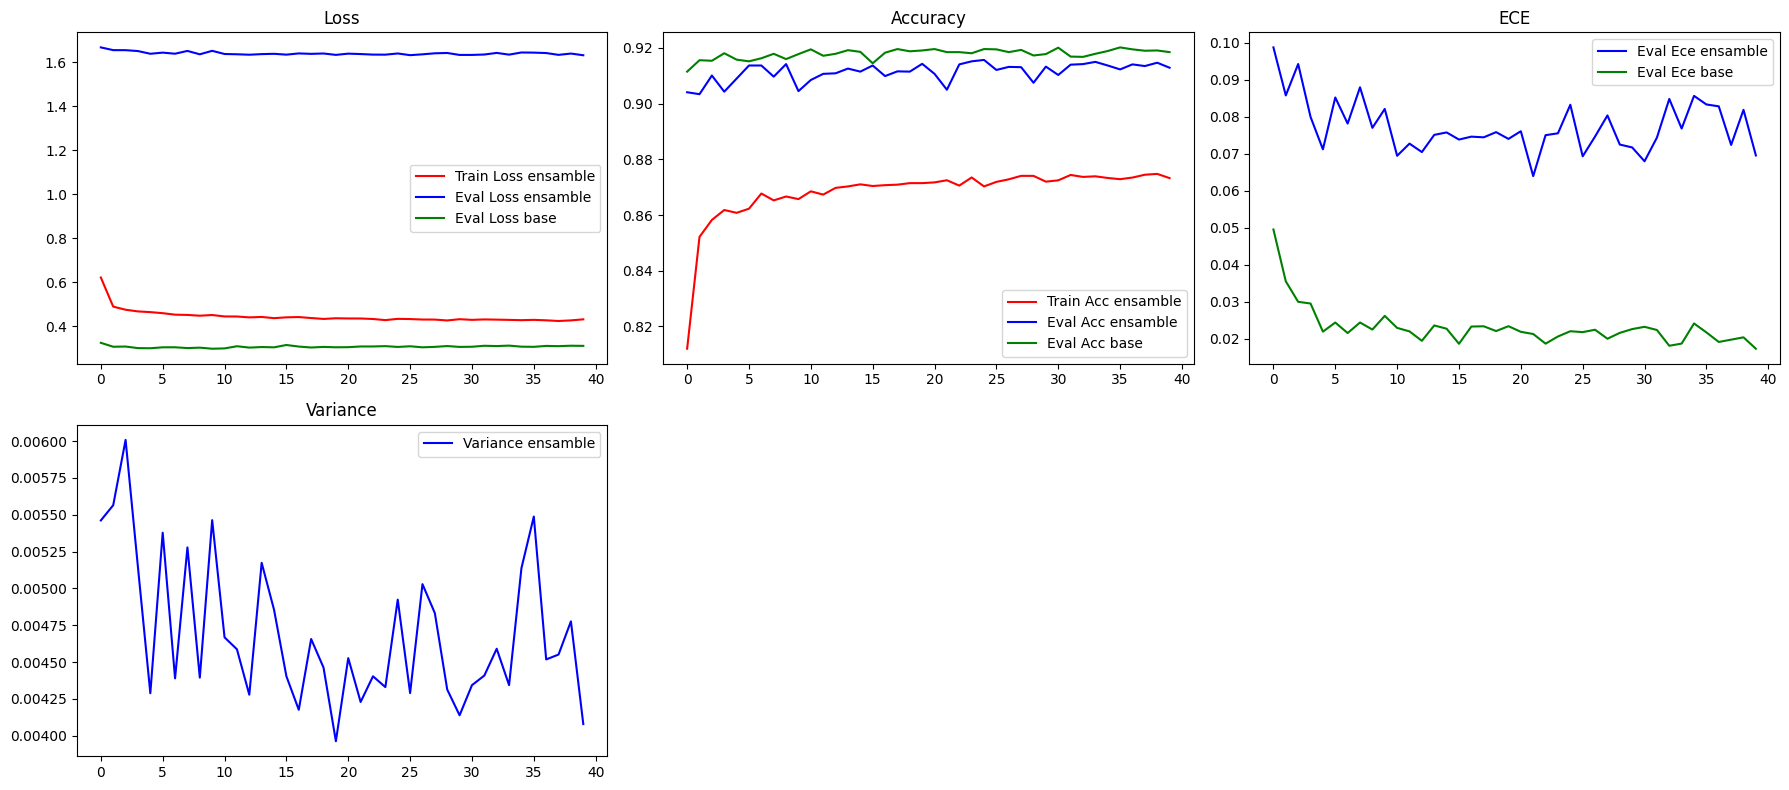

In [76]:
compare_train_results(ensamble_train_history, base_model_train_history)